In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [42]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

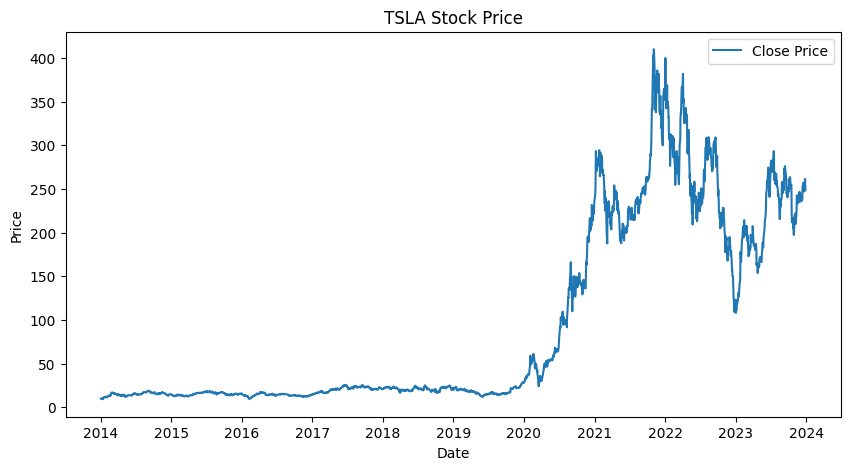

In [43]:
file_path = '/kaggle/input/tesla-stock-price-with-indicators-10-years/tsla_2014_2023.csv'  
data = pd.read_csv(file_path)

data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Plot the closing price
plt.figure(figsize=(10, 5))
plt.plot(data['close'], label='Close Price')
plt.title('TSLA Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [44]:
prices = data['close'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

In [45]:
seq_length = 50
X, y = [], []

for i in range(seq_length, len(prices_scaled)):
    X.append(prices_scaled[i-seq_length:i, 0])  # Sequence of 50 previous prices
    y.append(prices_scaled[i, 0])  # Next price

X = np.array(X)
y = np.array(y)

train_size = int(len(X) * 0.8)
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

In [46]:
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(2) 
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(2)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [47]:
input_size = 1
hidden_size = 50
output_size = 1

lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
linear = nn.Linear(hidden_size, output_size)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(list(lstm.parameters()) + list(linear.parameters()), lr=0.001)

epochs = 100  

for epoch in range(epochs):
    lstm.train()
    
    # Initialize the hidden state
    hidden_cell = (torch.zeros(1, X_train.size(0), hidden_size),
                   torch.zeros(1, X_train.size(0), hidden_size))
    
    optimizer.zero_grad()
    
    y_pred, hidden_cell = lstm(X_train, hidden_cell)
    y_pred = linear(y_pred[:, -1, :])  
    
    loss = loss_function(y_pred, y_train)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1} loss: {loss.item()}')


Epoch 1 loss: 0.049428485333919525
Epoch 11 loss: 0.04255100339651108
Epoch 21 loss: 0.03326808661222458
Epoch 31 loss: 0.007702450267970562
Epoch 41 loss: 0.0015860003186389804
Epoch 51 loss: 0.0007890114793553948
Epoch 61 loss: 0.0006512286490760744
Epoch 71 loss: 0.0005589573411270976
Epoch 81 loss: 0.0005207589128986001
Epoch 91 loss: 0.000503953022416681


In [48]:
lstm.eval()
hidden_cell = (torch.zeros(1, X_test.size(0), hidden_size),
               torch.zeros(1, X_test.size(0), hidden_size))
y_pred, hidden_cell = lstm(X_test, hidden_cell)
y_pred = linear(y_pred[:, -1, :])  

y_pred = scaler.inverse_transform(y_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on the test set: {mse:.2f}')

Mean Squared Error on the test set: 445.44


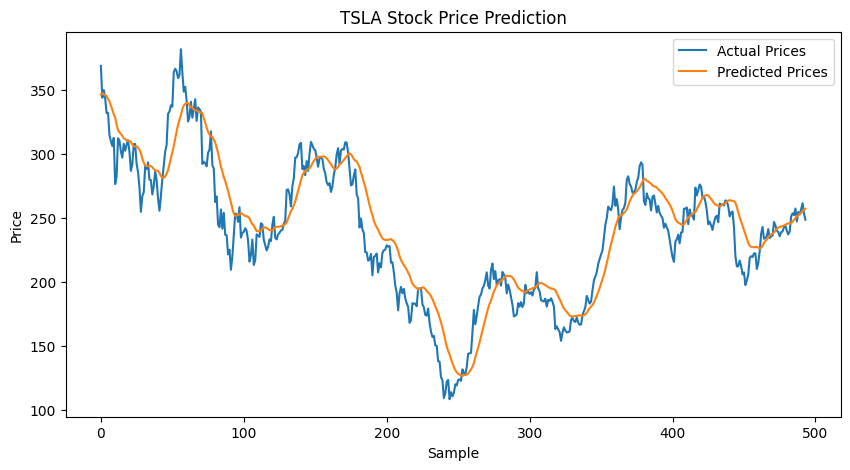

In [49]:
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual Prices')
plt.plot(y_pred, label='Predicted Prices')
plt.title('TSLA Stock Price Prediction')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()
plt.show()